In [21]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, LabelEncoder
from sklearn.impute import SimpleImputer as Imputer # if we also look at numeric features
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split

from utils import combine_text_columns, SparseInteractions

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df = pd.read_csv("data/training_set.csv")

SCORING_METRIC = "roc_auc_ovr"

FEATURES = ["Description"]
LABEL = "Category"
NON_LABELS = [c for c in df.columns if c != LABEL]

# Select k best features in text vectors
chi_k = 300

TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

#dummy_labels = pd.get_dummies(df[LABEL])
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df[LABEL])

X_train, X_test, y_train, y_test = train_test_split(df[NON_LABELS], encoded_labels, random_state=42)

get_text_data = FunctionTransformer(lambda x: combine_text_columns(x, to_drop=[LABEL]), validate=False)


pl = Pipeline([
        ('feature_preprocessing ', FeatureUnion(
            transformer_list = [
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),
                    #('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                    #                                 alternate_sign=False, norm=None, binary=False,
                    #                                 ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, k=chi_k))
                ]))
             ]
        )),
        ('oversampler', SMOTE(random_state=42)),
        #('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced"), n_jobs=-1))
    ])

In [22]:
cv = cross_val_score(pl, X_train, y_train, cv=5, scoring=SCORING_METRIC)

print(f"\nMean cross validated {SCORING_METRIC} score: {np.mean(cv)}\n")

for fold, score in enumerate(cv):
    print(f"Score on fold {fold}: {score}")



Mean cross validated roc_auc_ovr score: 0.7261897347452363

Score on fold 0: 0.7273719681948515
Score on fold 1: 0.7267169758712138
Score on fold 2: 0.7252045647267831
Score on fold 3: 0.725606430427672
Score on fold 4: 0.7260487345056613


In [15]:
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)
print("\n", classification_report(y_test, y_pred))


               precision    recall  f1-score   support

           0       0.02      0.06      0.03       335
           1       0.02      0.09      0.04       276
           2       0.37      0.09      0.14       954
           3       0.15      0.04      0.07      1177
           4       0.14      0.28      0.19       220
           5       0.06      0.03      0.04      1024
           6       0.17      0.19      0.18       710
           7       0.05      0.22      0.08       199
           8       0.55      0.31      0.40       667
           9       0.14      0.30      0.19       203
          10       0.26      0.06      0.10      3332
          11       0.05      0.22      0.09       254
          12       0.04      0.06      0.05       294
          13       0.20      0.14      0.16      1173
          14       0.02      0.07      0.04       271
          15       0.08      0.05      0.06       520
          16       0.10      0.03      0.05      1328
          17       0.19  

Text(0.5, 1.0, 'Confusion matrix')

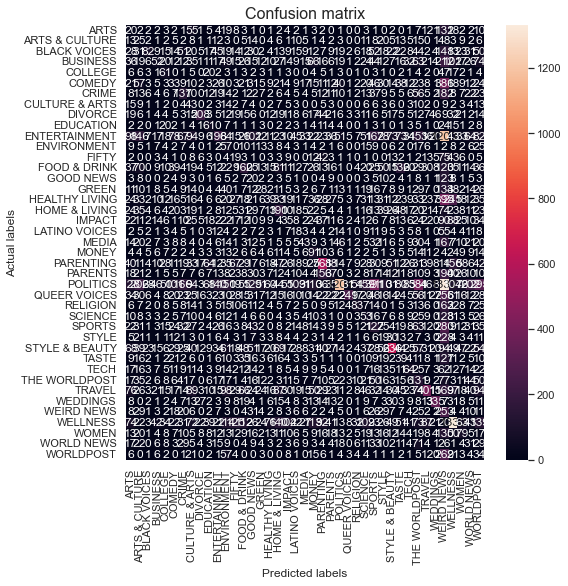

In [16]:
cm = confusion_matrix(
    y_test,
    y_pred
)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title("Confusion matrix", size=16)

In [17]:
sample = df[LABEL].sample(3)
print(sample)



103657       GREEN
80374       SPORTS
10803     POLITICS
Name: Category, dtype: object


Text(0.5, 0, 'Number of ocurrences')

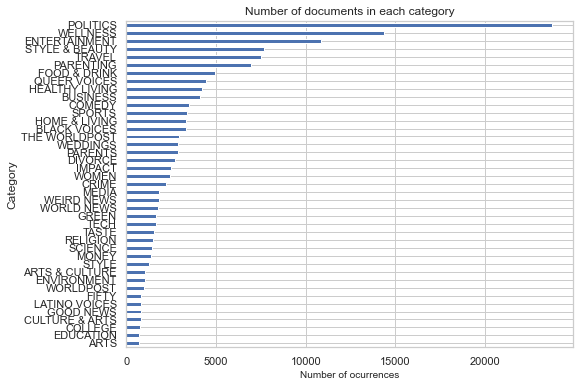

In [18]:
fig = plt.figure(figsize=(8,6))
df.groupby(LABEL)[FEATURES[0]].count().sort_values().plot.barh(
    ylim = 0, 
    title = 'Number of documents in each category'
    )
plt.xlabel('Number of ocurrences', fontsize = 10)